<a href="https://colab.research.google.com/github/rk119/F20DL-Group14-Submissions/blob/main/Part3_UG14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3 - Decision Trees

Decision trees are a type of supervised learning algorithm that are used for both classification and regression tasks.

**Basic Concept:**

*    *Tree Structure*: A decision tree is structured like an inverted tree, with a root at the top and branches leading to additional nodes or leaves. Each internal node represents a "test" or "decision" on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label (in classification) or a continuous value (in regression).


*    *Flow*: Starting from the root, data is split according to certain criteria at each node, with each path leading down to a leaf node that represents the final decision or prediction.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle
import cv2
import random
import warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import seaborn as sns

### **Loading data**

In [9]:
# Complete data path for reusability
complete_data_path = "/content/drive/MyDrive/F20DL_Data/Traffic_Sign/CompleteDataSet/"
# complete_data_path = "G:/My Drive/F20DL_Data/Traffic_Sign/CompleteDataSet/"

# X (Attributes) train file
x_train_all = pd.read_csv(complete_data_path + "x_train_all.csv")

# Y (Labels) train file
y_train_all = pd.read_csv(complete_data_path + "y_train_all.csv")

# X (Attributes) test file
x_test_all = pd.read_csv(complete_data_path + "x_test_all.csv")

# Y (Labels) test file
y_test_all = pd.read_csv(complete_data_path + "y_test_all.csv")

### **Preprocessing**

####Convert the dataframes to numpy arrays

In [10]:
x_train_array = x_train_all.to_numpy()
y_train_array = y_train_all.to_numpy()

In [11]:
x_test_array = x_test_all.to_numpy()
y_test_array = y_test_all.to_numpy()

####Function for image pre-processing

**Gaussian Blur:** Gaussian Blur is named after the mathematician Carl Friedrich Gauss. It uses a Gaussian function to transform each pixel in an image. The primary purpose is to create a blurring effect.
The technique involves a mathematical operation that takes a pixel and changes its value by averaging it with the values of nearby pixels. The extent of blurring is determined by the standard deviation of the Gaussian distribution, often referred to as the "sigma" or "radius" of the blur. A larger sigma results in more blurring.


**Adaptive Thresholding:** Adaptive thresholding is an image processing technique used to convert grayscale images to binary (black and white) images. It determines the threshold value based on the local pixel intensity distribution. This means the threshold value varies across the image, adapting to changes in lighting. Consequently, it's more effective in dealing with images with uneven lighting.

In [12]:
# Function to apply Gaussian blur and adaptive thresholding to images
def apply_gaussian_blur_and_adaptive_threshold(data, image_shape, kernel_size, sd, block_size, const):
    processed_images = []

    for image in data:
        # Reshape and convert to uint8
        reshaped_image = image.reshape(image_shape).astype(np.uint8)

        # Apply Gaussian Blur
        blurred_image = cv2.GaussianBlur(reshaped_image, kernel_size, sd)

        # Apply Adaptive Thresholding
        thresholded_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, block_size, const)
        processed_images.append(thresholded_image.flatten())

    return np.array(processed_images)

####The preprocessing pipeline

In [13]:
image_processing_transformer = FunctionTransformer(apply_gaussian_blur_and_adaptive_threshold, kw_args={
    'image_shape': (48, 48),
    'kernel_size': (5, 5),
    'sd': 1,
    'block_size': 11,
    'const': 2
})

In [14]:
preprocessing_pipeline = Pipeline([
    ('image_processing', image_processing_transformer)
])

#### Applying the preprocessing to the datasets

In [15]:
thresholded_x_train = preprocessing_pipeline.fit_transform(x_train_array)
thresholded_x_test = preprocessing_pipeline.transform(x_test_array)

In [16]:
thresholded_x_train

array([[  0,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255,   0]], dtype=uint8)

#### Visualize original VS pre-processed images

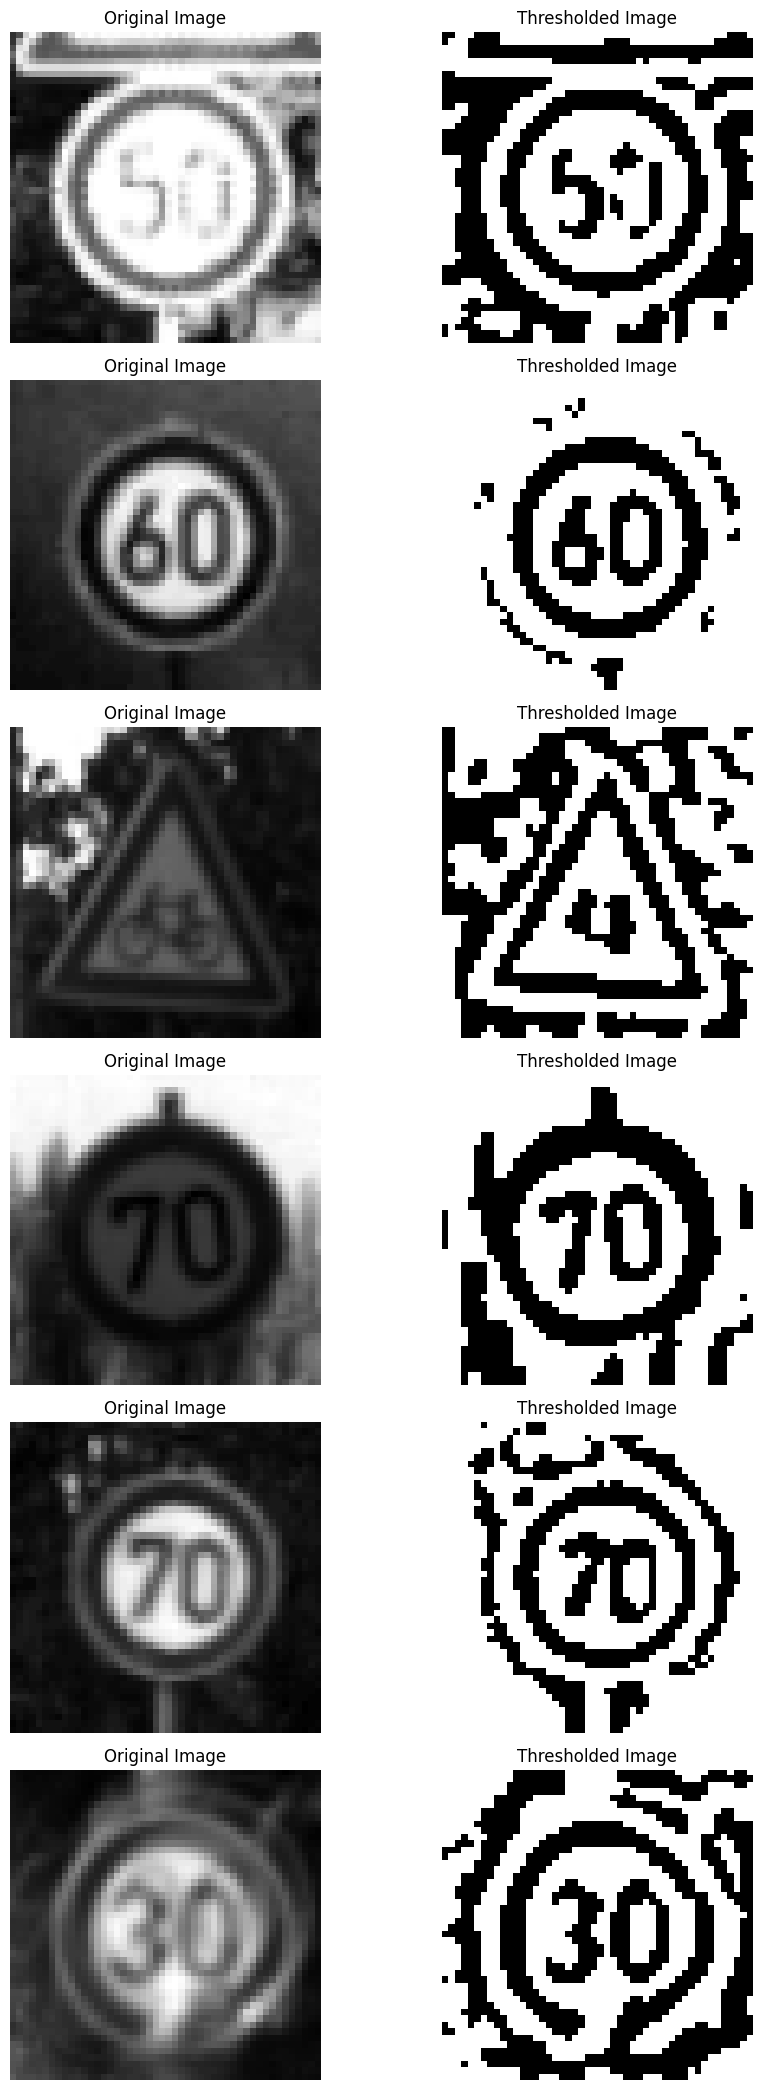

In [17]:
# Randomly selecting indices for visualization
random_indices = random.sample(range(x_train_array.shape[0]), 6)

def visualize_images(original, thresholded, indices, image_shape):
    fig, axes = plt.subplots(len(indices), 2, figsize=(10, len(indices) * 3.5))

    for i, idx in enumerate(indices):
        # Original Image
        original_image = original[idx].reshape(image_shape)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Thresholded Image
        thresholded_image = thresholded[idx].reshape(image_shape)
        axes[i, 1].imshow(thresholded_image, cmap='gray')
        axes[i, 1].set_title('Thresholded Image')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the images
visualize_images(x_train_array, thresholded_x_train, random_indices, (48, 48))

## **Creating Functions for Displaying results**

### Function to Generate the ROC Curves for every class

In [63]:
def gen_roc(y_prob, y_test, n_classes=10):

    # Initializing dictionaries to store the False Positive Rate (FPR), True Positive Rate (TPR) for each class and AUC (Area Under Curve)
    false_positive_rate = dict()
    true_positive_rate = dict()
    area_under_curve = dict()
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'orange']
    # Creating OnevrsAll for all the classes of the dataset
    create_onevrsalls = pd.get_dummies(y_test, drop_first=False).values

    # Calculate TPR, FPR, and AUC for each class.
    for i in range(n_classes):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(create_onevrsalls[:, i], y_prob[:, i])
        area_under_curve[i] = auc(false_positive_rate[i], true_positive_rate[i])

    # Initialize the plotting figure.
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plotting a diagonal line, which represents a random classifier and setting x,y limits, labels, title, legend and gridlines
    ax.plot([0, 1], [0, 1], linestyle='--')
     # Plotting the ROC curve for each class.
    for i in range(n_classes):
        ax.plot(false_positive_rate[i], true_positive_rate[i], color=colors[i], label='ROC curve (area = %0.2f) for label %i' % (area_under_curve[i], i))

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="best")
    sns.despine()



    # Displaying the plot
    plt.show()

### Function to generate the Macro Averaged ROC Curve

In [64]:
def plot_multiclass_roc_with_macro_avg(y_true, y_score_list, class_names, model_names, figsize=(10, 5)):

    # Determining the number of classes
    n_classes = len(class_names)

    plt.figure(figsize=figsize)

    # Binarize the true labels in a one-vs-all fashion for multiclass evaluation
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Iterating over each models score list
    for idx, y_score in enumerate(y_score_list):
        fpr_list = []
        tpr_list = []

        # Calculating FPR and TPR for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            fpr_list.append(fpr)
            tpr_list.append(tpr)

        # Calculating macro-average ROC curve by first finding all unique FPR values
        all_fpr = np.unique(np.concatenate(fpr_list))

        # Interpolating all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr_list[i], tpr_list[i])

        # Averaging the interpolated TPRs
        mean_tpr /= n_classes

        # Calculating the AUC for the macro-average ROC
        roc_auc_macro = auc(all_fpr, mean_tpr)

        # Plot the macro-average ROC curve for the current model
        plt.plot(all_fpr, mean_tpr, label=f'{model_names[idx]}, Macro-average ROC curve (area = {roc_auc_macro:0.2f})', linestyle='-', linewidth=2)

    # Plot the random guessing line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

    # Configure plot settings
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-averaged ROC curve')
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

### Function to display the Training and Testing Accuracies

In [65]:
def display_accuracies(clf, x_train, y_train, x_test, y_test):
  train_score = clf.score(x_train,y_train)
  test_score = clf.score(x_test,y_test)
  difference = train_score - test_score

  print("Accuracy on training set:",str(train_score))
  print("Accuracy on testing set:",str(test_score))
  print("Difference:",str(difference))

### Function to display the FPR and TPR

In [66]:
def display_TPR_FPR(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  FP = cm.sum(axis=0) - np.diag(cm)
  FN = cm.sum(axis=1) - np.diag(cm)
  TP = np.diag(cm)
  TN = cm.sum() - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  print(f"True Positive Rate: {TPR}")

  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  print(f"False Positive Rate: {FPR}")

  # Calculate the average TPR and FPR
  avg_TPR = np.mean(TPR)
  avg_FPR = np.mean(FPR)

  # Print the average TPR and FPR
  print(f"Average True Positive Rate: {avg_TPR}")
  print(f"Average False Positive Rate: {avg_FPR}")

### Function to Display the Confusion Matrix

In [67]:
class_names = [str(i) for i in range(10)]
def confusion_matrix_display(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_pred, display_labels = class_names, cmap="Greens")
  plt.show()

### Function to combine all results and print them together

In [68]:
def print_result(clf, x_train, y_train, x_test=None, y_test=None):
  if(x_test is None or y_test is None):
    x_test = x_train
    y_test = y_train
  y_pred = clf.predict(x_test)
  y_pred_proba = clf.predict_proba(x_test)
  print(classification_report(y_test, y_pred))
  print()
  confusion_matrix_display(y_test, y_pred)
  print()
  print("ROC Curve ")
  gen_roc(y_pred_proba, y_test)
  print()
  print("Macro Averaged ROC Curve: ")
  plot_multiclass_roc_with_macro_avg(y_test, [y_pred_proba], class_names, ["model"])
  print()
  display_TPR_FPR(y_test, y_pred)
  print()
  display_accuracies(clf, x_train, y_train, x_test, y_test)



## **Decision Tree Classifier on the training sets**

### On the normal training dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690




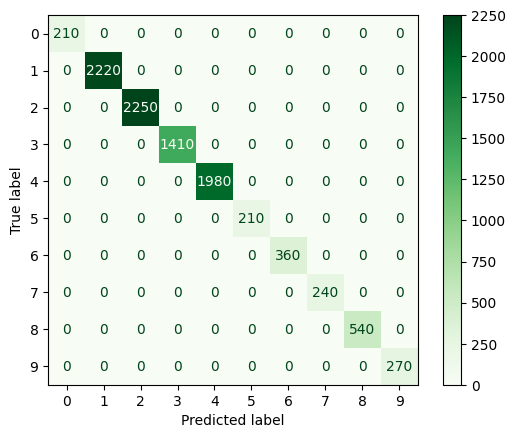


ROC Curve 


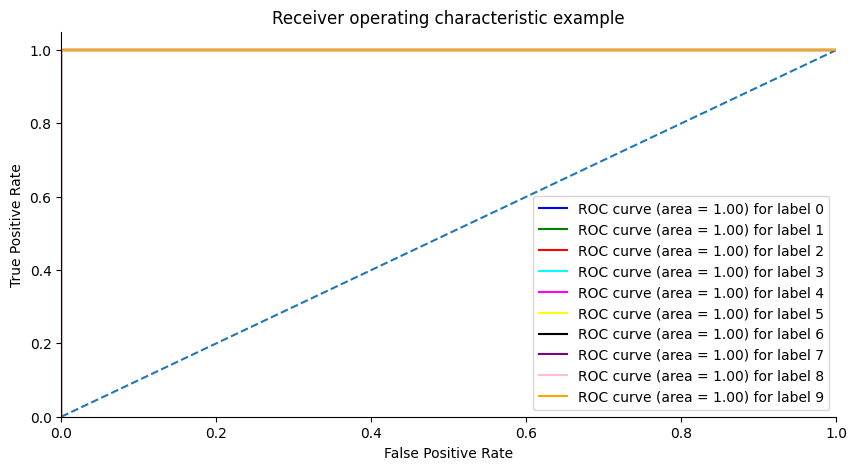


Macro Averaged ROC Curve: 


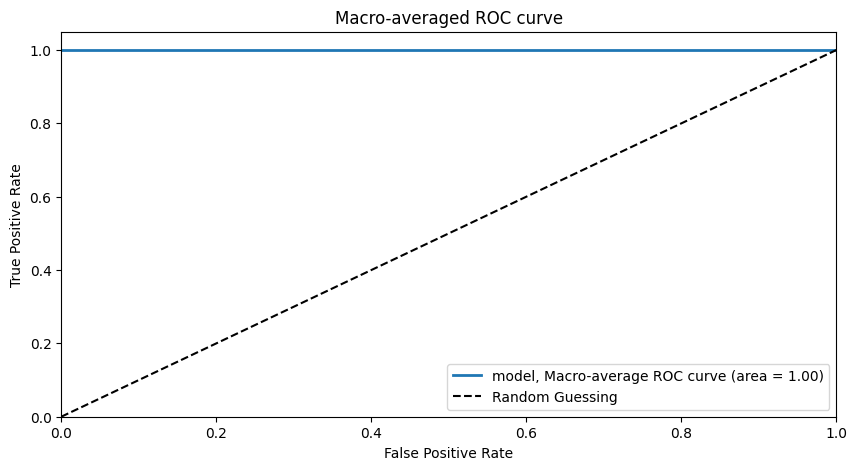


True Positive Rate: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
False Positive Rate: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Average True Positive Rate: 1.0
Average False Positive Rate: 0.0

Accuracy on training set: 1.0
Accuracy on testing set: 1.0
Difference: 0.0


In [69]:
# Initializing the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

clf.fit(x_train_array, y_train_array.ravel())

print_result(clf, x_train_array, y_train_array.ravel())

### On the pre-processed training dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690




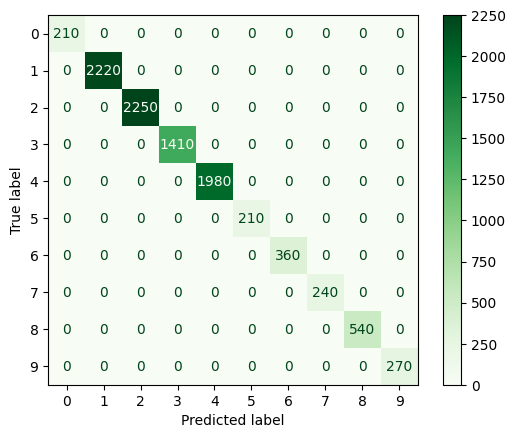


ROC Curve 


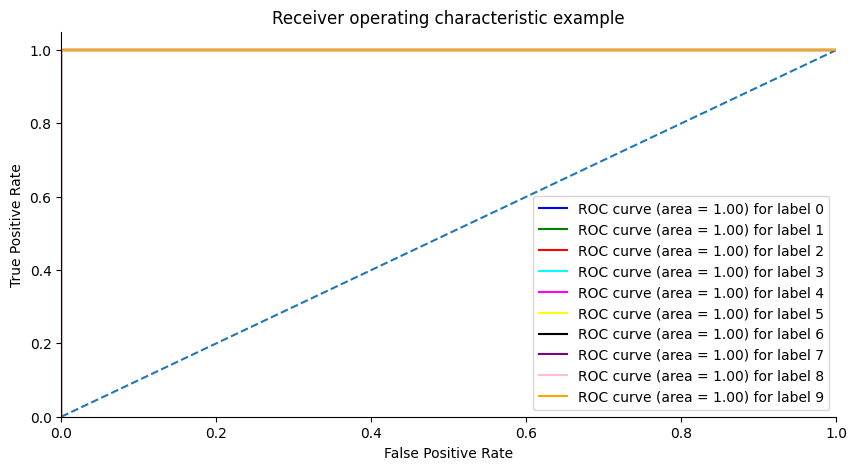


Macro Averaged ROC Curve: 


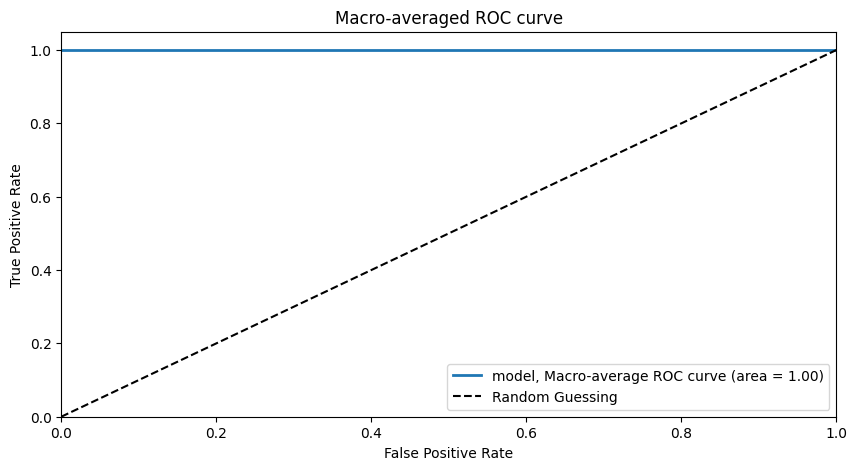


True Positive Rate: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
False Positive Rate: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Average True Positive Rate: 1.0
Average False Positive Rate: 0.0

Accuracy on training set: 1.0
Accuracy on testing set: 1.0
Difference: 0.0


In [70]:
clf_on_thresholding = DecisionTreeClassifier(random_state=42)

clf_on_thresholding.fit(thresholded_x_train, y_train_array.ravel())

train_accuracy_thresholding = clf_on_thresholding.score(thresholded_x_train, y_train_array.ravel())

print_result(clf_on_thresholding, thresholded_x_train, y_train_array.ravel())

**Note:** Both models (normal and thresholded datasets) achieved a perfect accuracy of 1.00 on the training dataset indicating possibly overfitting.

### 10 Fold Cross Validation on Normal Dataset

In [ ]:
scoring = {
      'accuracy': 'accuracy',
      'precision_weighted': 'precision_weighted',
      'recall_weighted': 'recall_weighted',
      'f1_weighted': 'f1_weighted',
      'roc_auc_ovr': 'roc_auc_ovr'
    }
cv_results = cross_validate(clf, thresholded_x_train, y_train_array.ravel(), cv=10, scoring=scoring)

print("10-Fold Cross-Validation Results:\n")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_weighted'].mean())
print("Recall:", cv_results['test_recall_weighted'].mean())
print("F1 Score:", cv_results['test_f1_weighted'].mean())
print("ROC AUC:", cv_results['test_roc_auc_ovr'].mean())

10-Fold Cross-Validation Results:

Accuracy: 0.8223942208462333
Precision: 0.8225909730312276
Recall: 0.8223942208462333
F1 Score: 0.8206123959022161
ROC AUC: 0.879300992371278


### 10 Fold Cross Validation on Pre-processed Dataset

In [ ]:
scoring = {
      'accuracy': 'accuracy',
      'precision_weighted': 'precision_weighted',
      'recall_weighted': 'recall_weighted',
      'f1_weighted': 'f1_weighted',
      'roc_auc_ovr': 'roc_auc_ovr'
    }
cv_results = cross_validate(clf, thresholded_x_train, y_train_array.ravel(), cv=10, scoring=scoring)

print("10-Fold Cross-Validation Results:\n")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_weighted'].mean())
print("Recall:", cv_results['test_recall_weighted'].mean())
print("F1 Score:", cv_results['test_f1_weighted'].mean())
print("ROC AUC:", cv_results['test_roc_auc_ovr'].mean())

10-Fold Cross-Validation Results:

Accuracy: 0.8223942208462333
Precision: 0.8225909730312276
Recall: 0.8223942208462333
F1 Score: 0.8206123959022161
ROC AUC: 0.879300992371278


## **Testing Decision Classifier on the testing set**

#### On the normal training dataset

In [71]:
y_pred_test = clf.predict(x_test_array)
y_prob_test = clf.predict_proba(x_test_array)

              precision    recall  f1-score   support

           0       0.27      0.32      0.29        60
           1       0.72      0.78      0.75       720
           2       0.76      0.74      0.75       750
           3       0.67      0.69      0.68       450
           4       0.73      0.72      0.72       660
           5       0.43      0.48      0.46        60
           6       0.46      0.40      0.43        90
           7       0.27      0.30      0.29        60
           8       0.57      0.43      0.49       150
           9       0.65      0.51      0.57        90

    accuracy                           0.69      3090
   macro avg       0.55      0.54      0.54      3090
weighted avg       0.69      0.69      0.68      3090




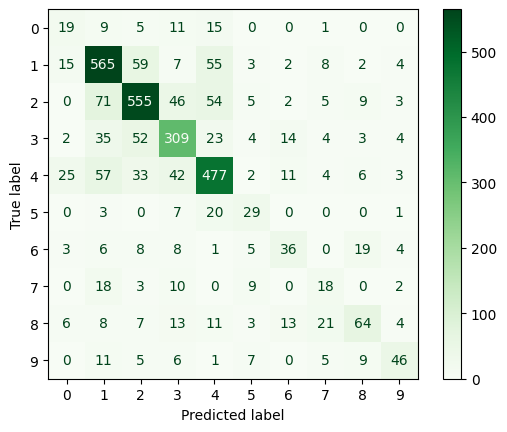


ROC Curve 


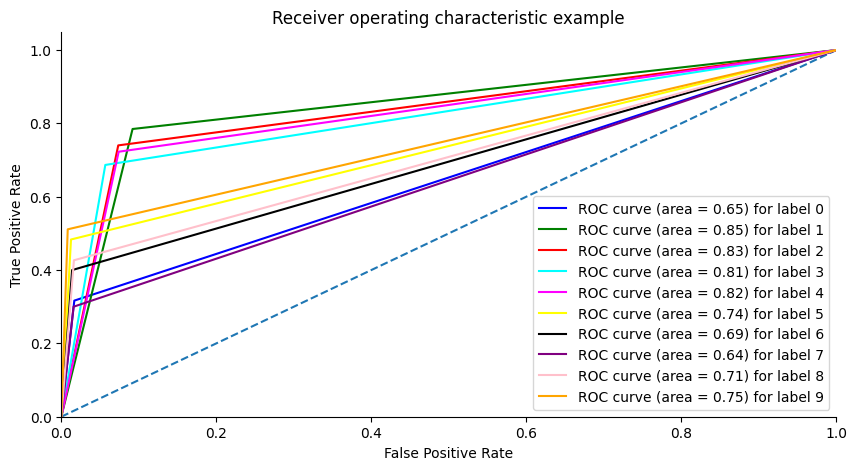


Macro Averaged ROC Curve: 


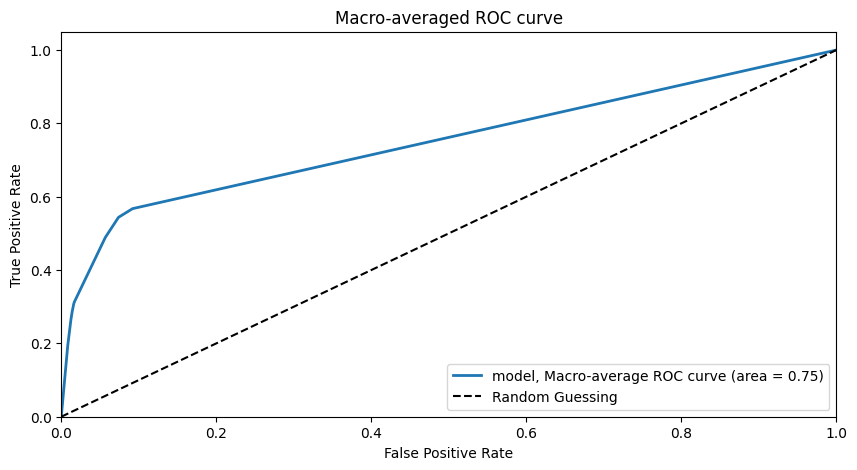


True Positive Rate: [0.31666667 0.78472222 0.74       0.68666667 0.72272727 0.48333333
 0.4        0.3        0.42666667 0.51111111]
False Positive Rate: [0.01683168 0.09198312 0.07350427 0.05681818 0.07407407 0.01254125
 0.014      0.01584158 0.01632653 0.00833333]
Average True Positive Rate: 0.5371893939393939
Average False Positive Rate: 0.03802540371571221

Accuracy on training set: 1.0
Accuracy on testing set: 0.6854368932038835
Difference: 0.31456310679611654


In [72]:
print_result(clf, x_train_array, y_train_array.ravel(), x_test_array, y_test_array.ravel())

#### On the pre-processed training dataset

In [73]:
y_pred_test_thresholding = clf_on_thresholding.predict(thresholded_x_test)
y_prob_test_thresholding = clf_on_thresholding.predict_proba(thresholded_x_test)

              precision    recall  f1-score   support

           0       0.68      0.60      0.64        60
           1       0.91      0.88      0.89       720
           2       0.84      0.91      0.87       750
           3       0.79      0.77      0.78       450
           4       0.92      0.88      0.90       660
           5       0.71      0.73      0.72        60
           6       0.67      0.70      0.68        90
           7       0.73      0.77      0.75        60
           8       0.84      0.75      0.79       150
           9       0.65      0.73      0.69        90

    accuracy                           0.84      3090
   macro avg       0.77      0.77      0.77      3090
weighted avg       0.85      0.84      0.84      3090




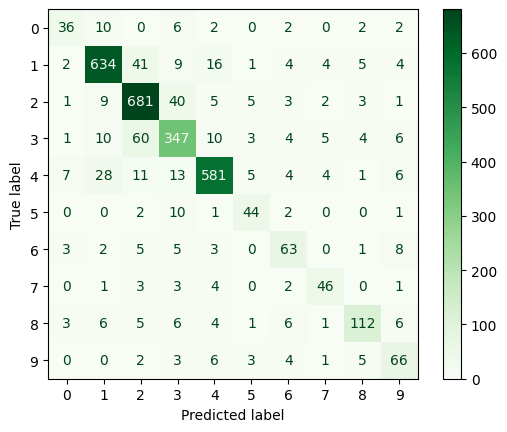


ROC Curve 


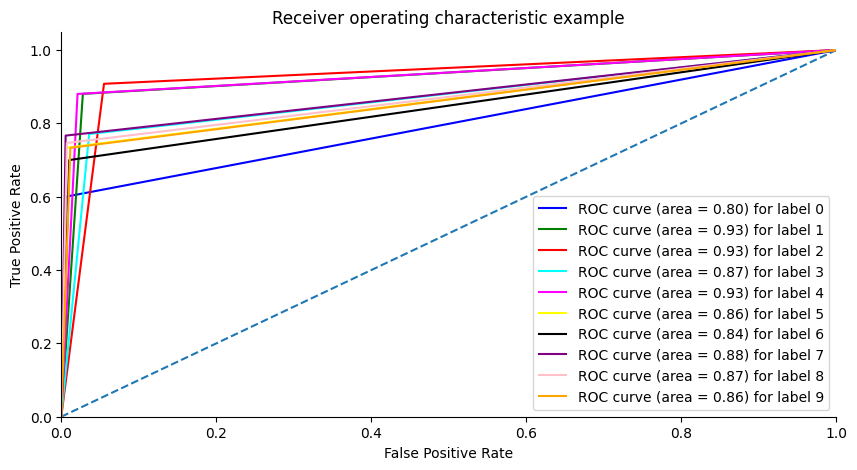


Macro Averaged ROC Curve: 


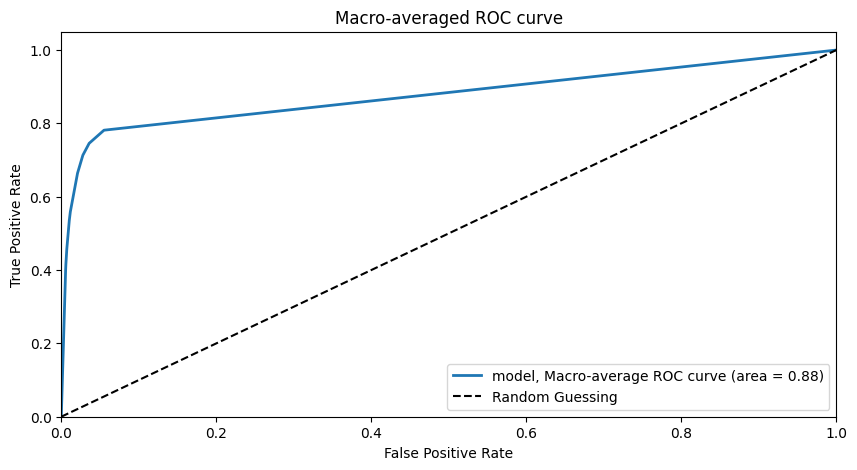


True Positive Rate: [0.6        0.88055556 0.908      0.77111111 0.88030303 0.73333333
 0.7        0.76666667 0.74666667 0.73333333]
False Positive Rate: [0.00561056 0.0278481  0.05512821 0.03598485 0.02098765 0.00594059
 0.01033333 0.00561056 0.00714286 0.01166667]
Average True Positive Rate: 0.7719969696969697
Average False Positive Rate: 0.018625338251433834

Accuracy on training set: 1.0
Accuracy on testing set: 0.8446601941747572
Difference: 0.15533980582524276


In [74]:
print_result(clf_on_thresholding, thresholded_x_train, y_train_array.ravel(), thresholded_x_test, y_test_array.ravel())

**Note:** The F1-scores, precision, and recall are better on the thresholded dataset compared to the normal dataset. This improvement is particularly notable in underrepresented classes, where the preprocessing steps might have helped in making the features of these classes more distinguishable.

## **Exploring Different Parameters**

#### Using Random Search to find optimal parameters

**Random Search:** Random Search is a technique used for hyperparameter optimization in machine learning models. It is a method of selecting the best hyperparameters for a learning algorithm, where a fixed number of hyperparameter settings is sampled from specified probability distributions. This approach contrasts with Grid Search, where a systematic, exhaustive search is performed through a specified subset of the hyperparameter space of the learning algorithm.

In [76]:
param_dist = {
    "max_depth": [3, None] + list(range(5, 15)),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11),
    "min_impurity_decrease": [0, 0.1, 0.01, 0.001, 0.0001],
    "ccp_alpha": [0, 0.1, 0.01, 0.001, 0.0001]
}

In [77]:
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=100, cv=10, verbose=1, random_state=42, scoring='accuracy'
)

**For the Pre-processed dataset**

In [78]:
random_search.fit(thresholded_x_train, y_train_array.ravel())

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'ccp_alpha': [0, 0.1, 0.01, 0.001,
                                                      0.0001],
                                        'max_depth': [3, None, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14],
                                        'min_impurity_decrease': [0, 0.1, 0.01,
                                                                  0.001,
                                                                  0.0001],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e845ed39d80>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e845ece7cd0>},
                   random_state=42, scoring='accuracy', verbose=1)

In [79]:
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'ccp_alpha': 0, 'max_depth': 14, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score: 0.828689370485036


              precision    recall  f1-score   support

           0       0.71      0.60      0.65        60
           1       0.91      0.87      0.89       720
           2       0.85      0.92      0.88       750
           3       0.78      0.77      0.77       450
           4       0.91      0.88      0.90       660
           5       0.80      0.75      0.78        60
           6       0.72      0.74      0.73        90
           7       0.82      0.75      0.78        60
           8       0.84      0.80      0.82       150
           9       0.68      0.76      0.72        90

    accuracy                           0.85      3090
   macro avg       0.80      0.78      0.79      3090
weighted avg       0.85      0.85      0.85      3090




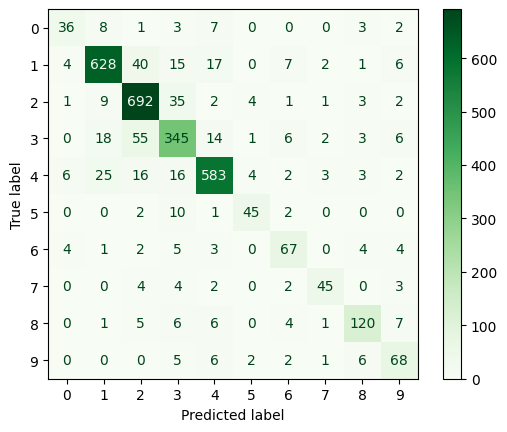


ROC Curve 


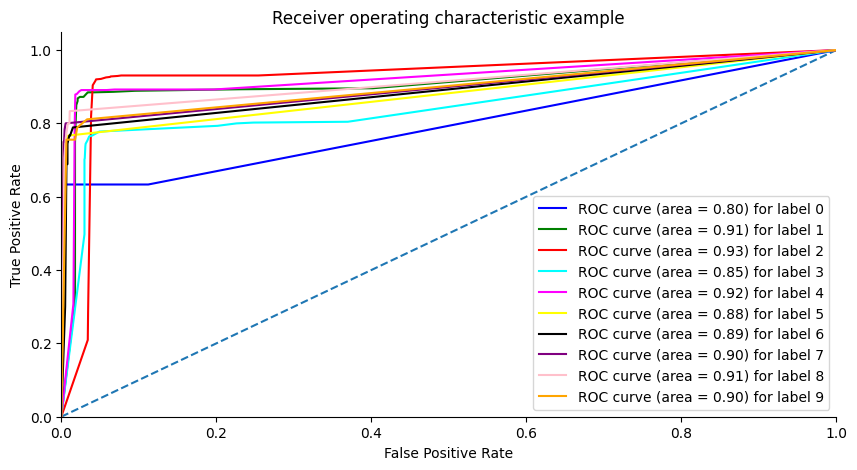


Macro Averaged ROC Curve: 


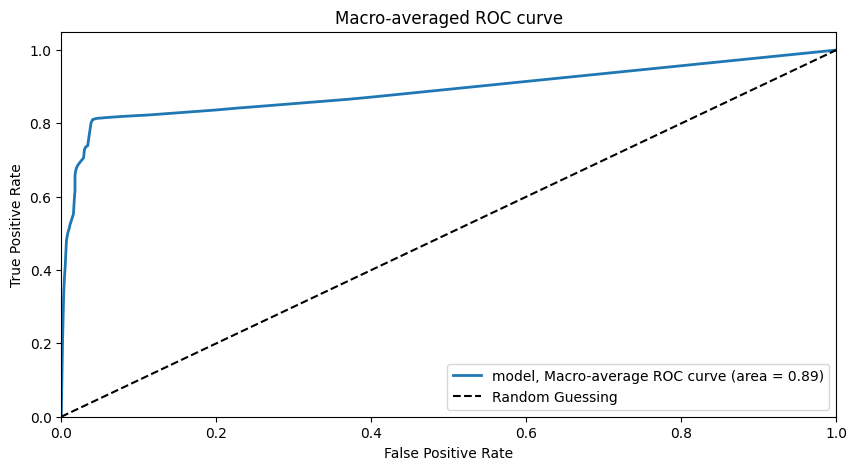


True Positive Rate: [0.6        0.87222222 0.92266667 0.76666667 0.88333333 0.75
 0.74444444 0.75       0.8        0.75555556]
False Positive Rate: [0.0049505  0.02616034 0.0534188  0.0375     0.02386831 0.00363036
 0.00866667 0.00330033 0.00782313 0.01066667]
Average True Positive Rate: 0.7844888888888889
Average False Positive Rate: 0.017998510443259355

Accuracy on training set: 0.9801857585139319
Accuracy on testing set: 0.8508090614886732
Difference: 0.12937669702525867


In [80]:
# Predict using the best model
best_model = random_search.best_estimator_
y_pred_optimized = best_model.predict(thresholded_x_test)

print_result(best_model, thresholded_x_train, y_train_array.ravel(), thresholded_x_test, y_test_array.ravel())

## **Different criterions for the quality of split in decision tree**

**Best parameters achieved using random search**

In [81]:
best_params = {
    'ccp_alpha': 0,
    'max_depth': 14,
    'min_impurity_decrease': 0.0001,
    'min_samples_leaf': 1,
    'min_samples_split': 5
}

#### Gini Impurity

*   Gini impurity measures the frequency at which any element of the
dataset will be mislabeled when it is randomly labeled according to the distribution of labels in the dataset.

*   A Gini impurity of 0 means all elements in the subset belong to the same class (pure), while higher values indicate more impurity.

In [82]:
clf_gini = DecisionTreeClassifier(
    criterion='gini',
    ccp_alpha=best_params['ccp_alpha'],
    max_depth=best_params['max_depth'],
    min_impurity_decrease=best_params['min_impurity_decrease'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

In [83]:
clf_gini.fit(thresholded_x_train, y_train_array.ravel())
y_pred_gini = clf_gini.predict(thresholded_x_test)

Decision Tree with Gini Criterion:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65        60
           1       0.91      0.87      0.89       720
           2       0.85      0.92      0.88       750
           3       0.78      0.77      0.77       450
           4       0.91      0.88      0.90       660
           5       0.80      0.75      0.78        60
           6       0.72      0.74      0.73        90
           7       0.82      0.75      0.78        60
           8       0.84      0.80      0.82       150
           9       0.68      0.76      0.72        90

    accuracy                           0.85      3090
   macro avg       0.80      0.78      0.79      3090
weighted avg       0.85      0.85      0.85      3090




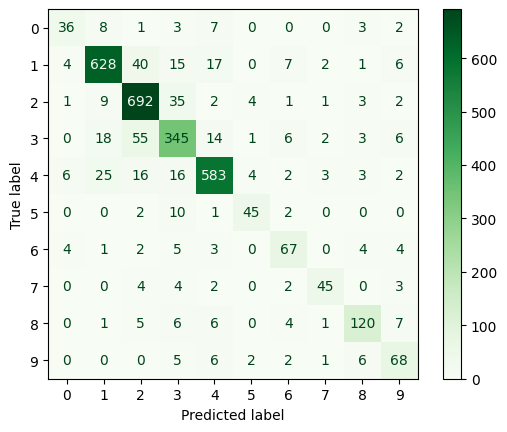


ROC Curve 


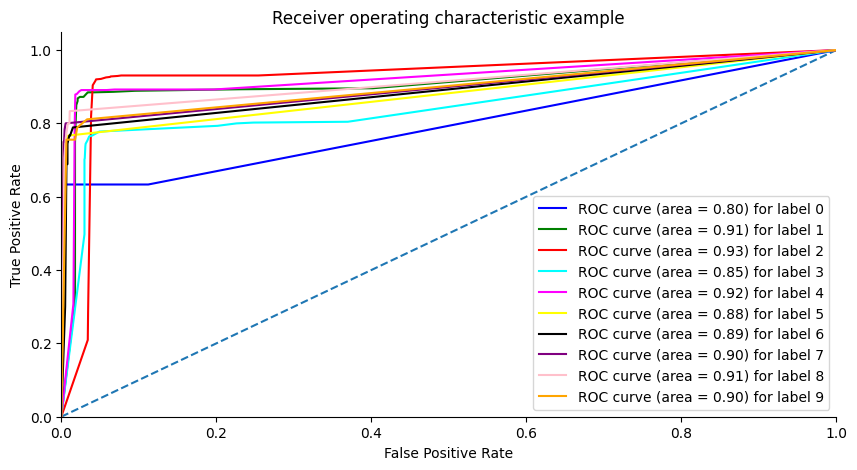


Macro Averaged ROC Curve: 


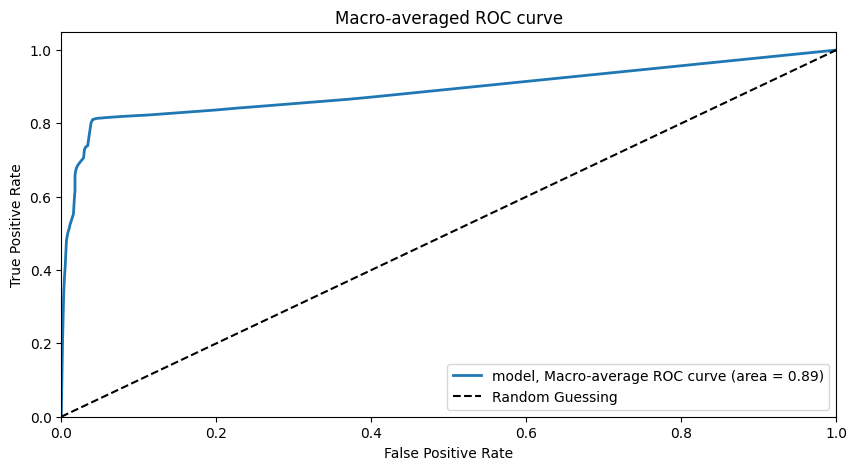


True Positive Rate: [0.6        0.87222222 0.92266667 0.76666667 0.88333333 0.75
 0.74444444 0.75       0.8        0.75555556]
False Positive Rate: [0.0049505  0.02616034 0.0534188  0.0375     0.02386831 0.00363036
 0.00866667 0.00330033 0.00782313 0.01066667]
Average True Positive Rate: 0.7844888888888889
Average False Positive Rate: 0.017998510443259355

Accuracy on training set: 0.9801857585139319
Accuracy on testing set: 0.8508090614886732
Difference: 0.12937669702525867


In [85]:
print("Decision Tree with Gini Criterion:")
print_result(clf_gini, thresholded_x_train, y_train_array.ravel(), thresholded_x_test, y_test_array.ravel())

#### Entropy

*   Entropy, originating from information theory, measures the amount of information disorder or uncertainty.

*   An entropy of 0 indicates no uncertainty (complete purity), while higher values indicate higher disorder.

In [86]:
clf_entropy = DecisionTreeClassifier(
    criterion='entropy',
    ccp_alpha=best_params['ccp_alpha'],
    max_depth=best_params['max_depth'],
    min_impurity_decrease=best_params['min_impurity_decrease'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

In [87]:
clf_entropy.fit(thresholded_x_train, y_train_array.ravel())
y_pred_entropy = clf_entropy.predict(thresholded_x_test)

Decision Tree with Entropy Criterion:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        60
           1       0.91      0.88      0.89       720
           2       0.81      0.92      0.86       750
           3       0.76      0.69      0.72       450
           4       0.92      0.88      0.90       660
           5       0.68      0.92      0.78        60
           6       0.78      0.80      0.79        90
           7       0.90      0.87      0.88        60
           8       0.88      0.71      0.79       150
           9       0.78      0.77      0.77        90

    accuracy                           0.85      3090
   macro avg       0.81      0.82      0.81      3090
weighted avg       0.85      0.85      0.84      3090




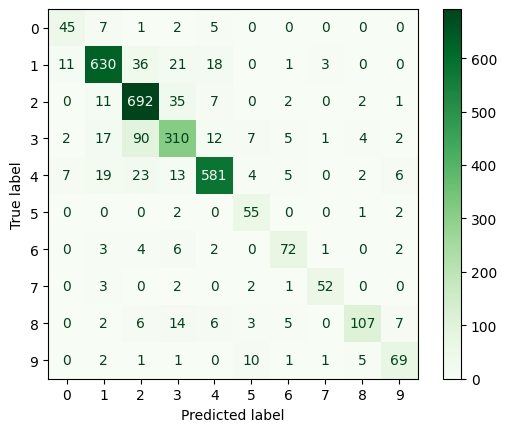


ROC Curve 


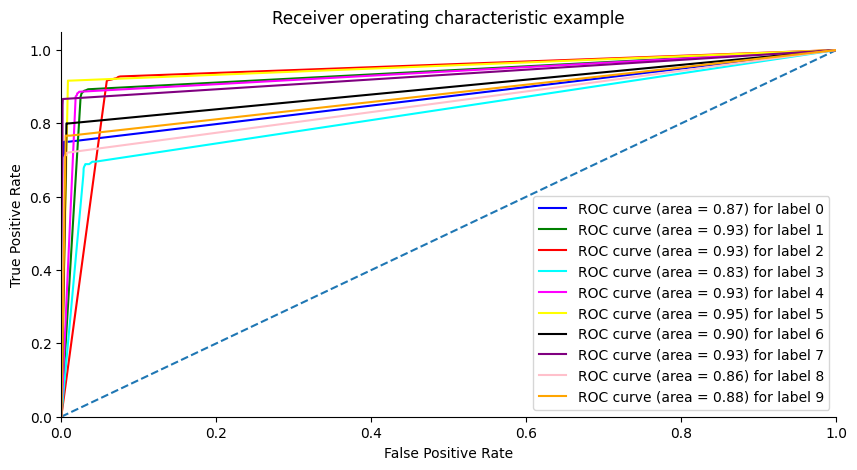


Macro Averaged ROC Curve: 


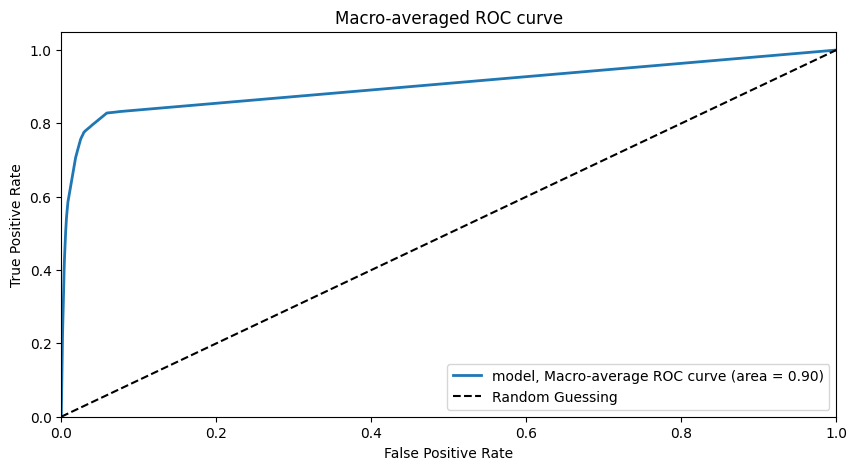


True Positive Rate: [0.75       0.875      0.92266667 0.68888889 0.88030303 0.91666667
 0.8        0.86666667 0.71333333 0.76666667]
False Positive Rate: [0.00660066 0.02700422 0.06880342 0.03636364 0.02057613 0.00858086
 0.00666667 0.0019802  0.0047619  0.00666667]
Average True Positive Rate: 0.8180191919191919
Average False Positive Rate: 0.018800436053043594

Accuracy on training set: 0.9862745098039216
Accuracy on testing set: 0.845631067961165
Difference: 0.14064344184275657


In [88]:
print("Decision Tree with Entropy Criterion:")
print_result(clf_entropy, thresholded_x_train, y_train_array.ravel(), thresholded_x_test, y_test_array.ravel())

**Note**: Given these observations, we picked the Entropy as it suggests that it may be more adept at handling class imbalances, likely due to its inherent nature of measuring information disorder or uncertainty.

## **Reallocation, Train and Evaluate the Decision Tree Classifier**

In [89]:
# Combining original training and testing sets
combined_x = np.vstack((thresholded_x_train, thresholded_x_test))
combined_y = np.concatenate((y_train_array, y_test_array))

In [90]:
combined_x

array([[  0,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [91]:
combined_y

array([[0],
       [0],
       [0],
       ...,
       [3],
       [1],
       [0]])

#### 30% Reallocation

In [92]:
x_train_30, x_test_30, y_train_30, y_test_30 = train_test_split(combined_x, combined_y, test_size=0.30, random_state=42)

In [93]:
clf_30 = DecisionTreeClassifier(
    criterion='entropy',
    ccp_alpha=best_params['ccp_alpha'],
    max_depth=best_params['max_depth'],
    min_impurity_decrease=best_params['min_impurity_decrease'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
clf_30.fit(x_train_30, y_train_30.ravel())

DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=14,
                       min_impurity_decrease=0.0001, min_samples_split=5,
                       random_state=42)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        86
           1       0.90      0.90      0.90       890
           2       0.88      0.88      0.88       911
           3       0.82      0.81      0.81       549
           4       0.92      0.92      0.92       789
           5       0.77      0.88      0.82        68
           6       0.81      0.83      0.82       127
           7       0.92      0.91      0.92       108
           8       0.90      0.87      0.89       207
           9       0.78      0.77      0.77        99

    accuracy                           0.88      3834
   macro avg       0.85      0.86      0.85      3834
weighted avg       0.88      0.88      0.88      3834




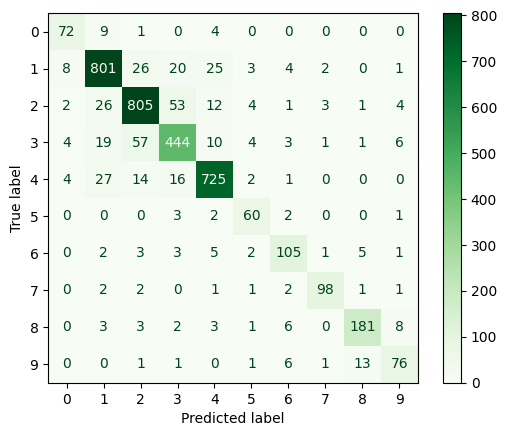


ROC Curve 


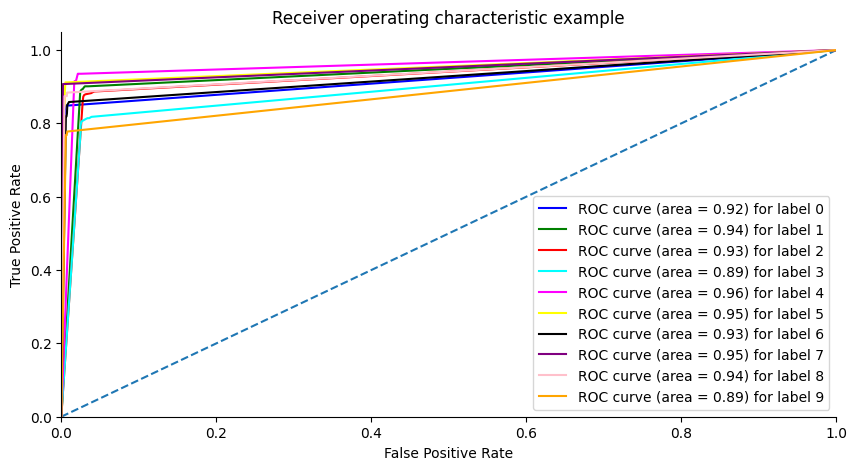


Macro Averaged ROC Curve: 


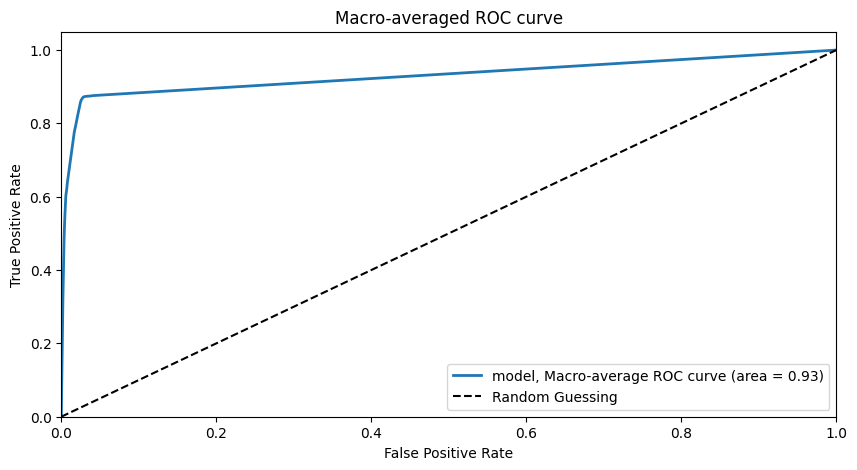


True Positive Rate: [0.8372093  0.9        0.88364435 0.80874317 0.91888466 0.88235294
 0.82677165 0.90740741 0.87439614 0.76767677]
False Positive Rate: [0.00480256 0.0298913  0.03660623 0.02983257 0.02036125 0.00477961
 0.006744   0.00214707 0.00578991 0.00589023]
Average True Positive Rate: 0.8607086387797525
Average False Positive Rate: 0.014684472849485649

Accuracy on training set: 0.9856919293539012
Accuracy on testing set: 0.8781950965049556
Difference: 0.10749683284894551


In [95]:
print_result(clf_30, x_train_30, y_train_30.ravel(), x_test_30, y_test_30.ravel())

#### 60% Reallocation

In [96]:
x_train_60, x_test_60, y_train_60, y_test_60 = train_test_split(combined_x, combined_y, test_size=0.60, random_state=42)

In [97]:
clf_60 = DecisionTreeClassifier(
    criterion='entropy',
    ccp_alpha=best_params['ccp_alpha'],
    max_depth=best_params['max_depth'],
    min_impurity_decrease=best_params['min_impurity_decrease'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

clf_60.fit(x_train_60, y_train_60.ravel())

DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=14,
                       min_impurity_decrease=0.0001, min_samples_split=5,
                       random_state=42)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       154
           1       0.90      0.89      0.90      1761
           2       0.86      0.88      0.87      1808
           3       0.79      0.77      0.78      1131
           4       0.92      0.92      0.92      1564
           5       0.74      0.78      0.76       170
           6       0.82      0.83      0.82       259
           7       0.84      0.87      0.86       193
           8       0.87      0.84      0.85       414
           9       0.72      0.67      0.69       214

    accuracy                           0.86      7668
   macro avg       0.82      0.82      0.82      7668
weighted avg       0.86      0.86      0.86      7668




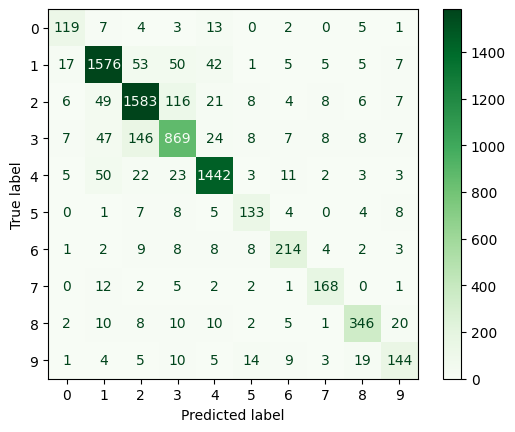


ROC Curve 


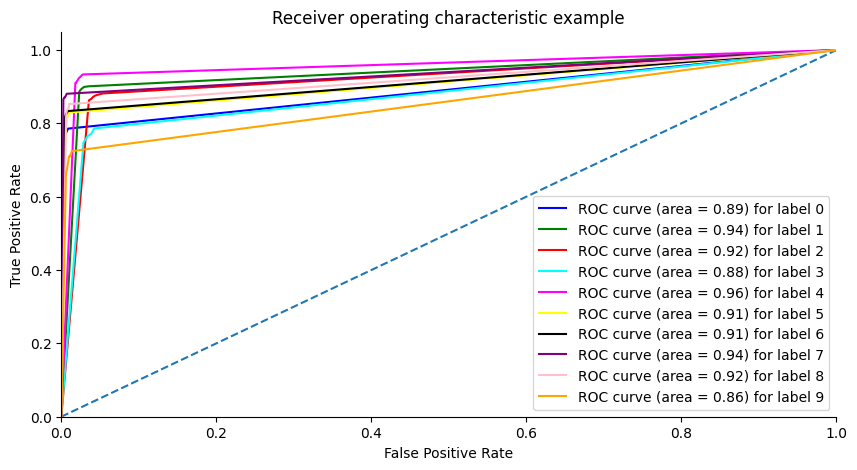


Macro Averaged ROC Curve: 


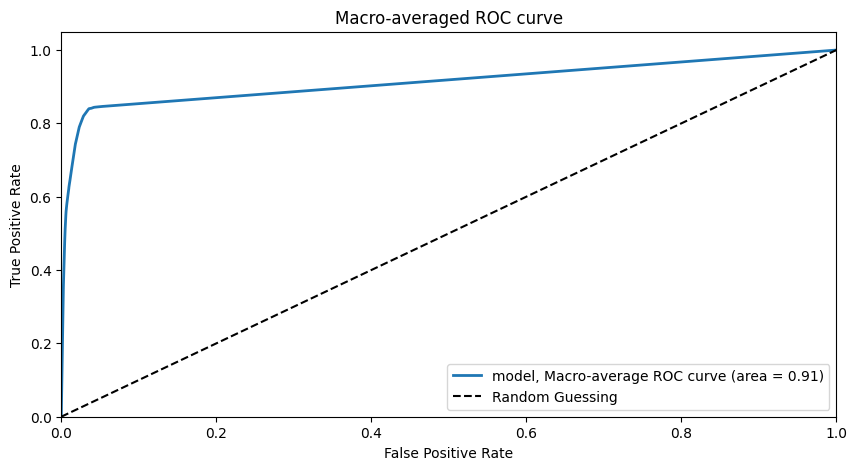


True Positive Rate: [0.77272727 0.89494605 0.8755531  0.7683466  0.92199488 0.78235294
 0.82625483 0.87046632 0.83574879 0.6728972 ]
False Positive Rate: [0.00519031 0.0308109  0.04368601 0.03564326 0.02129751 0.00613497
 0.00647861 0.00414716 0.00716846 0.0076469 ]
Average True Positive Rate: 0.822128798150149
Average False Positive Rate: 0.01682040852178148

Accuracy on training set: 0.9827856025039123
Accuracy on testing set: 0.8599374021909233
Difference: 0.12284820031298904


In [98]:
print_result(clf_60, x_train_60, y_train_60.ravel(), x_test_60, y_test_60.ravel())

## **Conclusion**

**30% Reallocation**

The model trained on 70% of the data and tested on 30% shows high precision, recall, and F1-scores across most classes with an overall accuracy of 0.88.
This high performance suggests that the model is effectively capturing the underlying patterns in the data.

**60% Reallocation**

With 40% of the data for training and 60% for testing, the model still maintains a high accuracy of 0.86, with similarly high precision and recall scores.
The consistency in performance, despite a significant reduction in training data, suggests good generalization ability. This is a positive indicator against overfitting.

**Overall**

The preprocessing steps (thresholding and Gaussian blur) played a crucial role in enhancing feature representation, particularly aiding in the improved performance of underrepresented classes.

The original model (in the very beginning) had significantly higher performance metrics on the training data initially indicating overfitting since the performance dropped in testing, compared to these experiments with optimized parameters and reallocation.

However, the consistent performance in the results after adjusting the parameters, even with reduced training data, suggests that the model is no longer overfitting as much on the training data.

The high performance (with a very 0.02% drop) on the larger testing set (60% reallocation) further reinforces the model's ability to generalize well.

## **Extra Model: Random Forest**

Random Forest is an ensemble learning method used for both classification and regression tasks in machine learning. It builds on the concept of decision trees, but instead of relying on a single decision tree, it combines the predictions from multiple decision trees to improve accuracy, robustness, and generalization ability.

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


def fit_random_forest(clf_rf, x_train, y_train, x_test=None, y_test=None):
  clf_rf.fit(x_train, y_train.ravel())
  if(x_test is not None or y_test is not None):
    print_result(clf_rf, x_train, y_train, x_test, y_test)
  else:
    print_result(clf_rf, x_train, y_train)


### **Training and testing on the train dataset**

#### On Normal Dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690




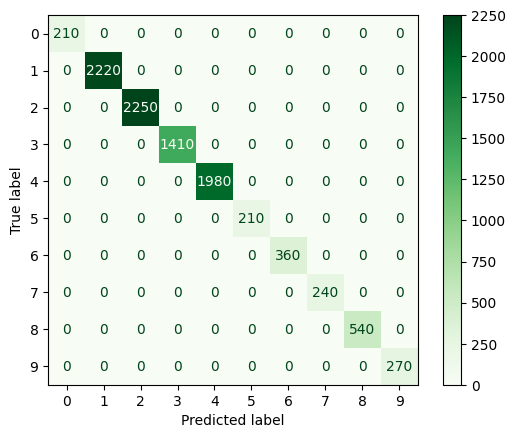


ROC Curve 


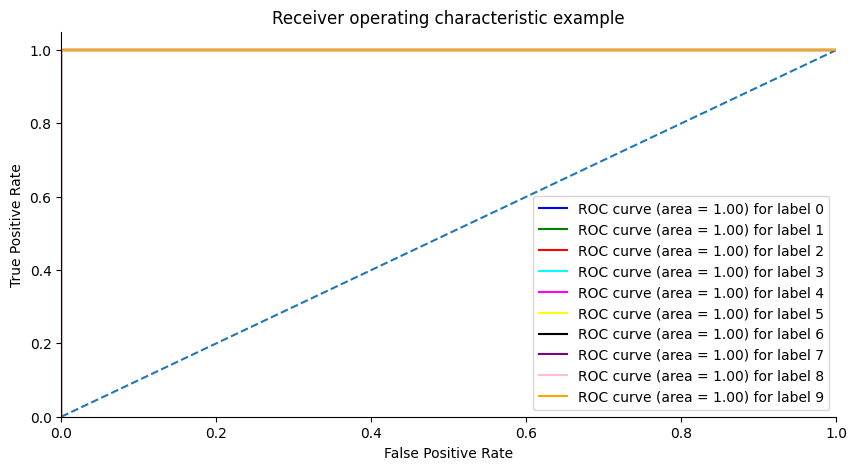


Macro Averaged ROC Curve: 


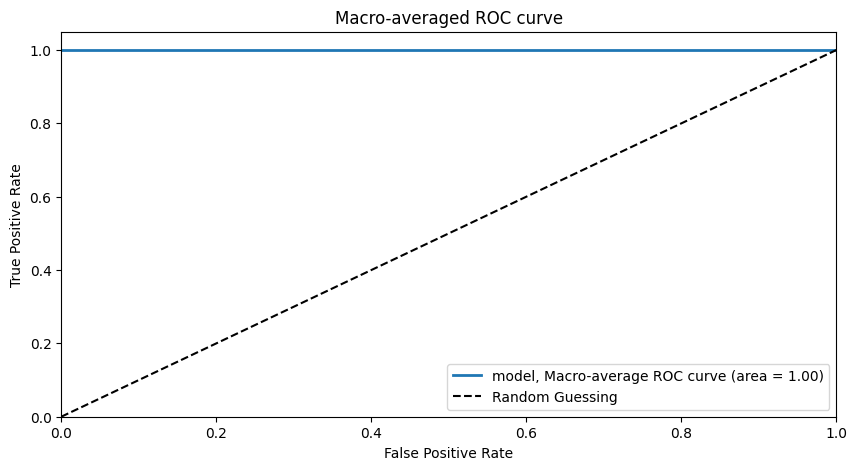


True Positive Rate: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
False Positive Rate: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Average True Positive Rate: 1.0
Average False Positive Rate: 0.0

Accuracy on training set: 1.0
Accuracy on testing set: 1.0
Difference: 0.0


In [110]:
random_forest_clf = RandomForestClassifier(random_state=42)
fit_random_forest(random_forest_clf, x_train_array, y_train_array.ravel())

#### On preprocessed dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       1.00      1.00      1.00      2220
           2       1.00      1.00      1.00      2250
           3       1.00      1.00      1.00      1410
           4       1.00      1.00      1.00      1980
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       360
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       540
           9       1.00      1.00      1.00       270

    accuracy                           1.00      9690
   macro avg       1.00      1.00      1.00      9690
weighted avg       1.00      1.00      1.00      9690




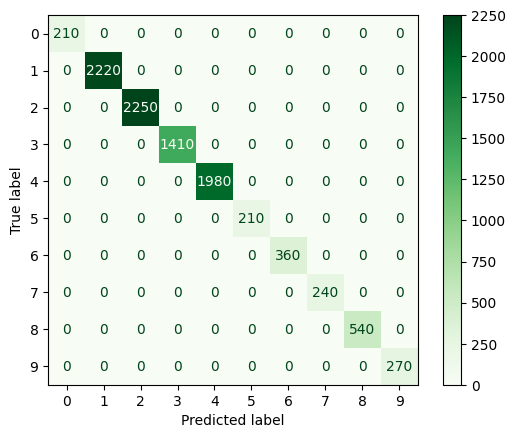


ROC Curve 


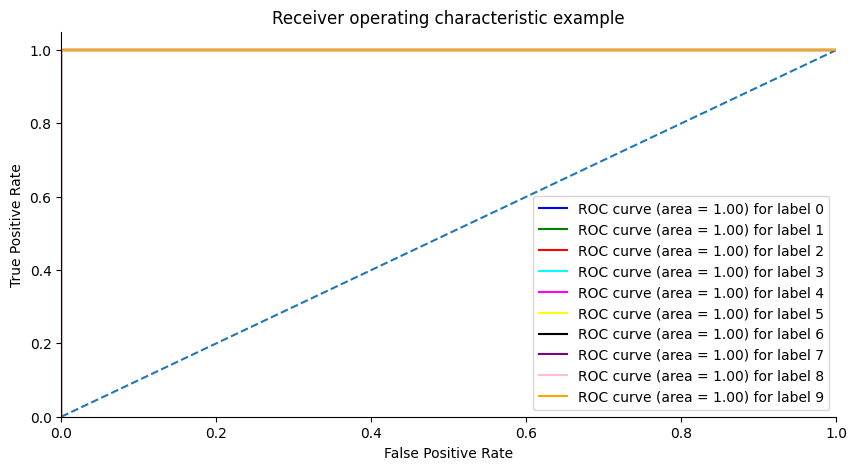


Macro Averaged ROC Curve: 


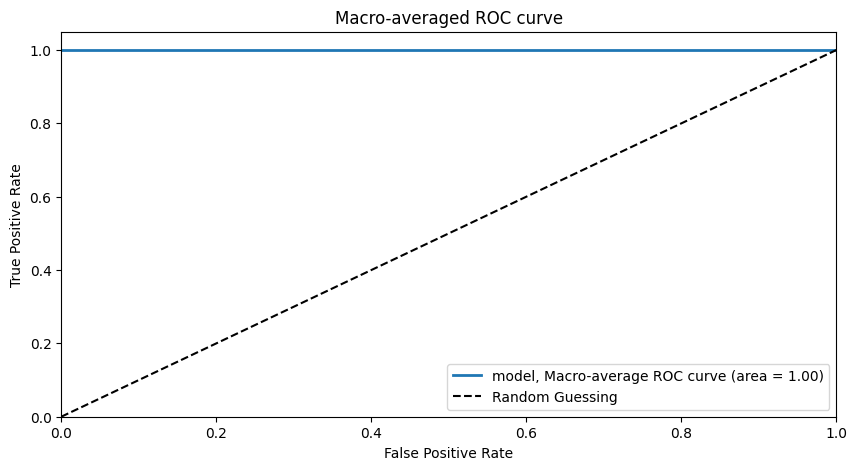


True Positive Rate: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
False Positive Rate: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Average True Positive Rate: 1.0
Average False Positive Rate: 0.0

Accuracy on training set: 1.0
Accuracy on testing set: 1.0
Difference: 0.0


In [111]:
random_forest_clf_thresholding = RandomForestClassifier(random_state=42)
fit_random_forest(random_forest_clf_thresholding, thresholded_x_train, y_train_array.ravel())

### **Using Cross Validation**

#### 10-Fold Cross Validation on Normal Data

In [112]:
scoring = {
      'accuracy': 'accuracy',
      'precision_weighted': 'precision_weighted',
      'recall_weighted': 'recall_weighted',
      'f1_weighted': 'f1_weighted',
      'roc_auc_ovr': 'roc_auc_ovr'
}

In [114]:
cv_results = cross_validate(random_forest_clf, x_train_array, y_train_array.ravel(), cv=10, scoring=scoring)

print("10-Fold Cross-Validation Results:\n")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_weighted'].mean())
print("Recall:", cv_results['test_recall_weighted'].mean())
print("F1 Score:", cv_results['test_f1_weighted'].mean())
print("ROC AUC:", cv_results['test_roc_auc_ovr'].mean())

10-Fold Cross-Validation Results:

Accuracy: 0.7890608875128998
Precision: 0.8051141104601399
Recall: 0.7890608875128998
F1 Score: 0.7840698914260777
ROC AUC: 0.9710789544892021


#### 10-Fold Cross Validation on Pre Proceessed Data

In [115]:
cv_results = cross_validate(random_forest_clf_thresholding, thresholded_x_train, y_train_array.ravel(), cv=10, scoring=scoring)

print("10-Fold Cross-Validation Results:\n")
print("Accuracy:", cv_results['test_accuracy'].mean())
print("Precision:", cv_results['test_precision_weighted'].mean())
print("Recall:", cv_results['test_recall_weighted'].mean())
print("F1 Score:", cv_results['test_f1_weighted'].mean())
print("ROC AUC:", cv_results['test_roc_auc_ovr'].mean())

10-Fold Cross-Validation Results:

Accuracy: 0.9278637770897834
Precision: 0.9302468341303127
Recall: 0.9278637770897834
F1 Score: 0.9254013010732555
ROC AUC: 0.9938932331098513


### **Testing Random Forest Classifier on the testing set**

#### On the normal testing dataset

              precision    recall  f1-score   support

           0       0.92      0.18      0.31        60
           1       0.74      0.87      0.80       720
           2       0.81      0.84      0.83       750
           3       0.75      0.80      0.77       450
           4       0.82      0.80      0.81       660
           5       0.86      0.50      0.63        60
           6       0.72      0.56      0.63        90
           7       0.95      0.30      0.46        60
           8       0.64      0.69      0.67       150
           9       0.73      0.49      0.59        90

    accuracy                           0.77      3090
   macro avg       0.79      0.60      0.65      3090
weighted avg       0.78      0.77      0.77      3090




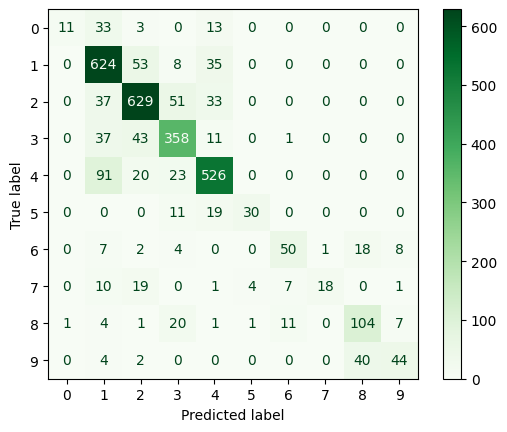


ROC Curve 


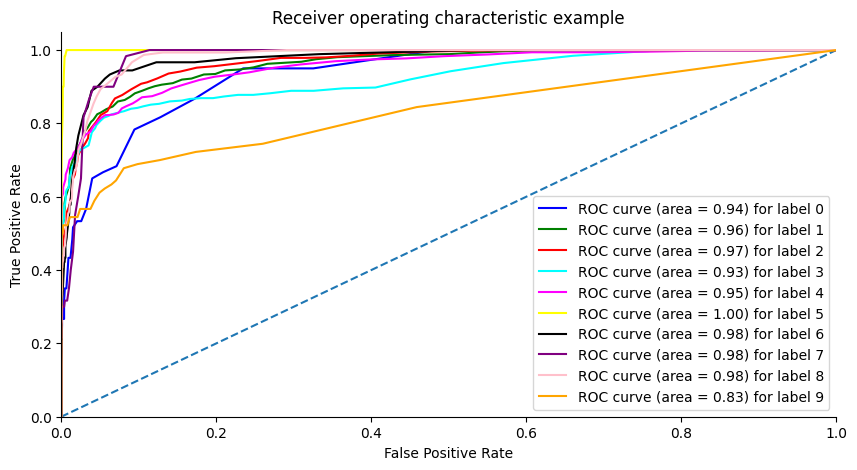


Macro Averaged ROC Curve: 


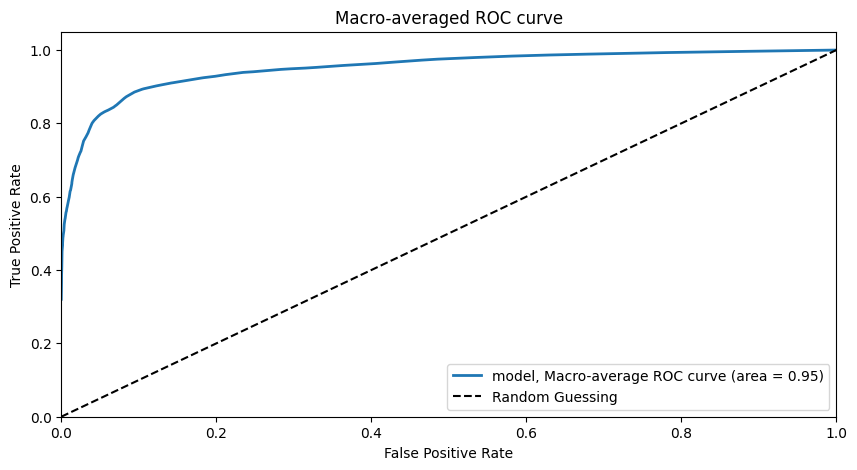


True Positive Rate: [0.18333333 0.86666667 0.83866667 0.79555556 0.7969697  0.5
 0.55555556 0.3        0.69333333 0.48888889]
False Positive Rate: [0.00033003 0.09409283 0.06111111 0.04431818 0.04650206 0.00165017
 0.00633333 0.00033003 0.01972789 0.00533333]
Average True Positive Rate: 0.6018969696969696
Average False Positive Rate: 0.027972896639291263

Accuracy on training set: 1.0
Accuracy on testing set: 0.7747572815533981
Difference: 0.22524271844660193


In [116]:
fit_random_forest(random_forest_clf, x_train_array, y_train_array.ravel(), x_test_array, y_test_array.ravel())

#### On Preprocessed data

              precision    recall  f1-score   support

           0       0.98      0.72      0.83        60
           1       0.97      0.97      0.97       720
           2       0.87      0.99      0.92       750
           3       0.93      0.82      0.87       450
           4       0.96      0.96      0.96       660
           5       0.98      0.90      0.94        60
           6       0.90      0.87      0.88        90
           7       1.00      0.87      0.93        60
           8       0.97      0.94      0.95       150
           9       0.99      0.96      0.97        90

    accuracy                           0.93      3090
   macro avg       0.95      0.90      0.92      3090
weighted avg       0.94      0.93      0.93      3090




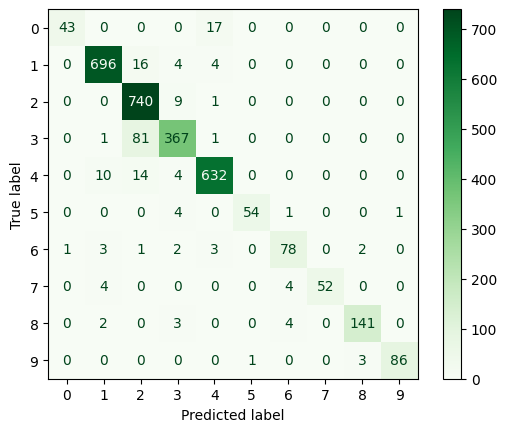


ROC Curve 


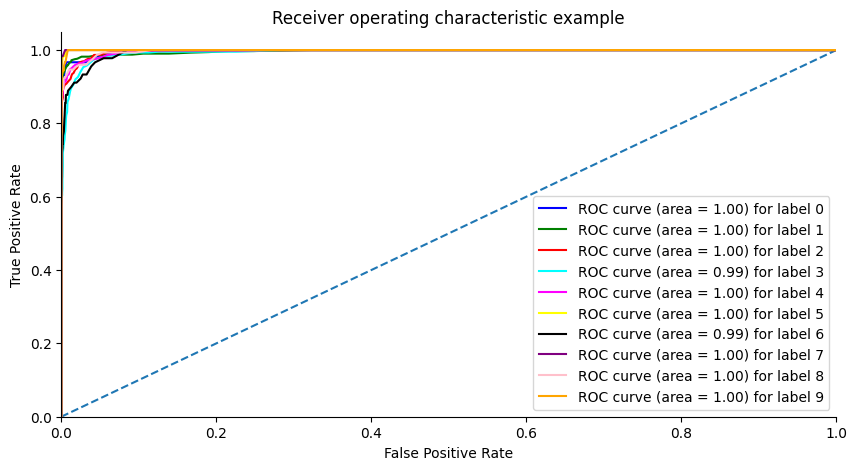


Macro Averaged ROC Curve: 


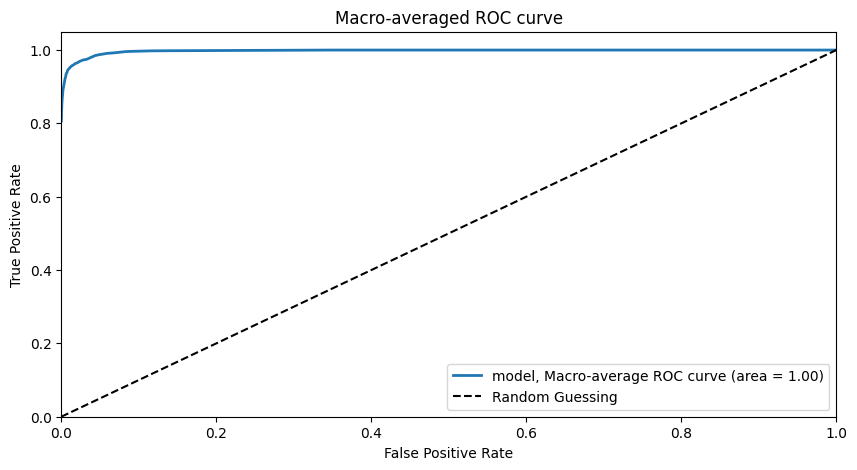


True Positive Rate: [0.71666667 0.96666667 0.98666667 0.81555556 0.95757576 0.9
 0.86666667 0.86666667 0.94       0.95555556]
False Positive Rate: [0.00033003 0.00843882 0.04786325 0.00984848 0.01069959 0.00033003
 0.003      0.         0.00170068 0.00033333]
Average True Positive Rate: 0.8972020202020202
Average False Positive Rate: 0.008254421936654266

Accuracy on training set: 1.0
Accuracy on testing set: 0.9349514563106797
Difference: 0.06504854368932034


In [117]:
fit_random_forest(random_forest_clf_thresholding, thresholded_x_train, y_train_array.ravel(), thresholded_x_test, y_test_array.ravel())

### **Reallocation, Train and Evaluate the Random Forest Classifier**


#### 30% Reallocation

              precision    recall  f1-score   support

           0       1.00      0.72      0.84        86
           1       0.97      0.98      0.97       890
           2       0.96      0.98      0.97       911
           3       0.97      0.94      0.95       549
           4       0.95      0.98      0.97       789
           5       1.00      0.96      0.98        68
           6       0.98      0.91      0.95       127
           7       1.00      1.00      1.00       108
           8       0.99      0.99      0.99       207
           9       1.00      0.90      0.95        99

    accuracy                           0.97      3834
   macro avg       0.98      0.94      0.96      3834
weighted avg       0.97      0.97      0.97      3834




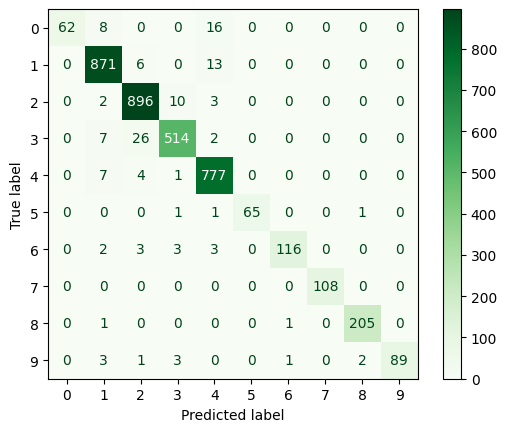


ROC Curve 


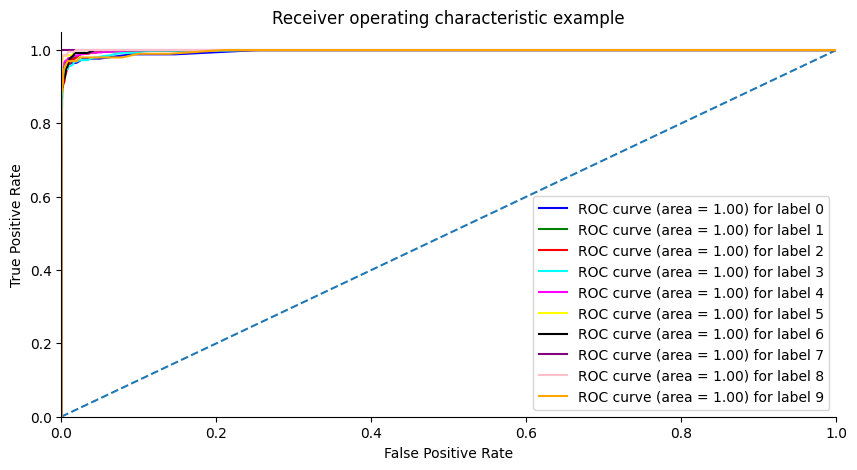


Macro Averaged ROC Curve: 


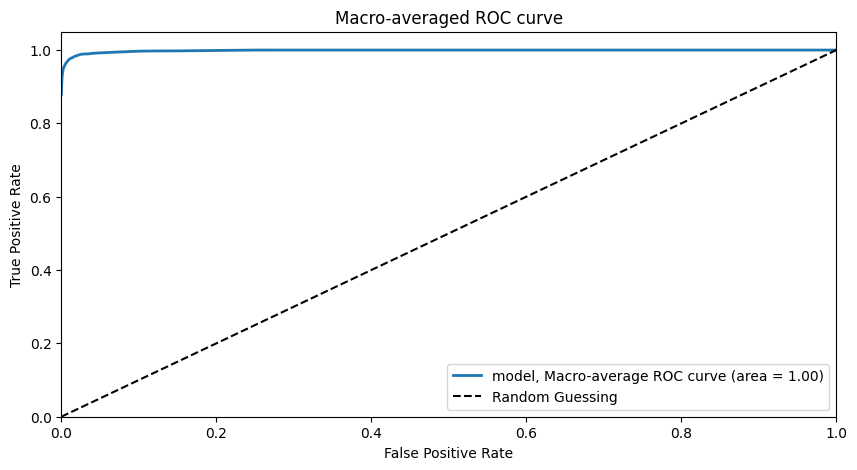


True Positive Rate: [0.72093023 0.97865169 0.98353458 0.93624772 0.98479087 0.95588235
 0.91338583 1.         0.99033816 0.8989899 ]
False Positive Rate: [0.         0.01019022 0.01368457 0.00547945 0.01247947 0.
 0.00053952 0.         0.00082713 0.        ]
Average True Positive Rate: 0.9362751335950505
Average False Positive Rate: 0.004320036432787647

Accuracy on training set: 1.0
Accuracy on testing set: 0.9658320292123109
Difference: 0.03416797078768907


In [118]:
fit_random_forest(random_forest_clf_thresholding, x_train_30, y_train_30.ravel(), x_test_30, y_test_30.ravel())

#### 60% Reallocation

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       154
           1       0.97      0.96      0.96      1761
           2       0.94      0.97      0.95      1808
           3       0.94      0.92      0.93      1131
           4       0.94      0.98      0.96      1564
           5       1.00      0.91      0.95       170
           6       0.94      0.90      0.92       259
           7       1.00      0.95      0.98       193
           8       0.97      0.96      0.96       414
           9       0.99      0.88      0.93       214

    accuracy                           0.95      7668
   macro avg       0.97      0.92      0.94      7668
weighted avg       0.95      0.95      0.95      7668




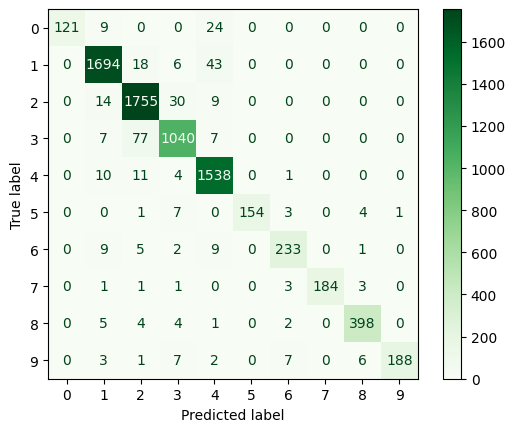


ROC Curve 


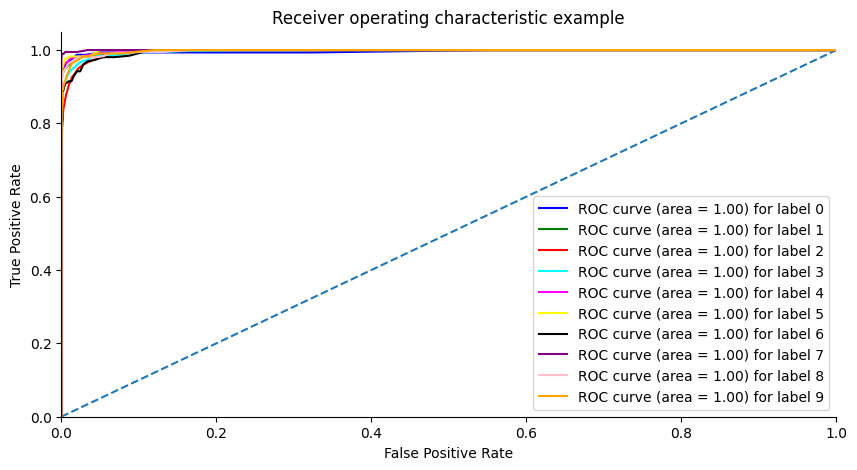


Macro Averaged ROC Curve: 


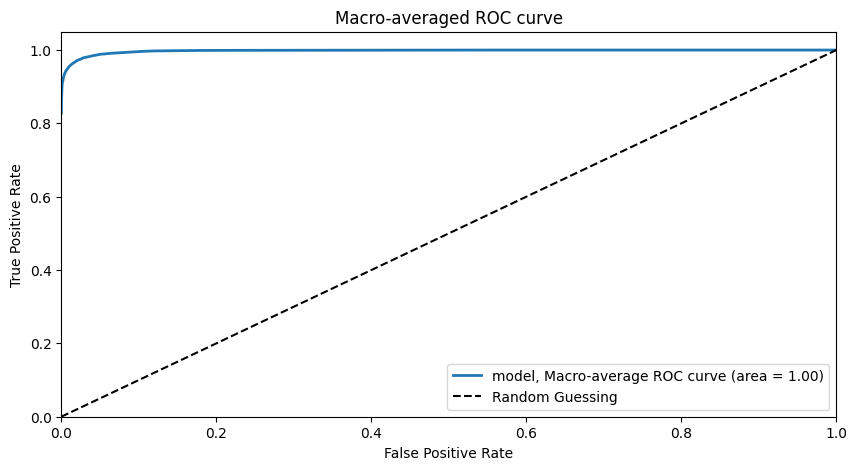


True Positive Rate: [0.78571429 0.96195344 0.97068584 0.91954023 0.98337596 0.90588235
 0.8996139  0.95336788 0.96135266 0.87850467]
False Positive Rate: [0.         0.00981886 0.02013652 0.0093315  0.01556356 0.
 0.00215954 0.         0.00192997 0.00013416]
Average True Positive Rate: 0.9219991209039348
Average False Positive Rate: 0.005907410178607178

Accuracy on training set: 1.0
Accuracy on testing set: 0.952660406885759
Difference: 0.04733959311424096


In [119]:
fit_random_forest(random_forest_clf_thresholding, x_train_60, y_train_60.ravel(), x_test_60, y_test_60.ravel())